# DPU example: YOLOv3
----

## Aim/s
* This notebooks shows an example of DPU applications. The application,as well as the DPU IP, is pulled from the official 
[Vitis AI Github Repository](https://github.com/Xilinx/Vitis-AI).

## References
* [Vitis AI Github Repository](https://www.xilinx.com/products/design-tools/vitis/vitis-ai.html).

## Last revised
* Jun 27, 2022
    * Initial revision
----

## 1. Prepare the overlay
We will download the overlay onto the board. 

In [1]:
from pynq_dpu import DpuOverlay
from pynq_peripherals import PmodGroveAdapter
overlay = DpuOverlay("dpu.bit")

In [2]:
overlay.PMODA

{'ip_name': 'iop_pmod0/mb_bram_ctrl',
 'rst_name': 'mb_iop_pmod0_reset',
 'intr_pin_name': 'iop_pmod0/dff_en_reset_vector_0/q',
 'intr_ack_name': 'mb_iop_pmod0_intr_ack',
 'mbtype': 'Pmod',
 'name': 'iop_pmod0'}

In [3]:
# Initiate pmod adapter
adapter = PmodGroveAdapter(overlay.PMODA, G4='grove_oled')

## 2. Utility functions

In this section, we will prepare a few functions for later use.

In [4]:
import os
import time
import numpy as np
import cv2
import random
import colorsys
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
from IPython.display import display, Image
%matplotlib inline

The `load_model()` method will automatically prepare the `graph`
which is used by VART.

**Note** For the KV260 board you may see TLS memory allocation errors if cv2 gets loaded before loading the vitis libraries in the Jupyter Lab environment. Make sure to load cv2 first in these cases.

In [5]:
overlay.load_model("tf_yolov3_voc.xmodel")

Let's first define a few useful preprocessing functions.

In [6]:
anchor_list = [10,13,16,30,33,23,30,61,62,45,59,119,116,90,156,198,373,326]
anchor_float = [float(x) for x in anchor_list]
anchors = np.array(anchor_float).reshape(-1, 2)

In [7]:
'''Get model classification information'''	
def get_class(classes_path):
    with open(classes_path) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names
    
classes_path = "img/voc_classes.txt"
class_names = get_class(classes_path)

In [8]:
num_classes = len(class_names)
hsv_tuples = [(1.0 * x / num_classes, 1., 1.) for x in range(num_classes)]
colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
colors = list(map(lambda x: 
                  (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), 
                  colors))
random.seed(0)
random.shuffle(colors)
random.seed(None)

All the yolo helper functions

In [9]:
'''resize image with unchanged aspect ratio using padding'''
def letterbox_image(image, size):
    ih, iw, _ = image.shape
    w, h = size
    scale = min(w/iw, h/ih)
    #print(scale)
    
    nw = int(iw*scale)
    nh = int(ih*scale)
    #print(nw)
    #print(nh)

    image = cv2.resize(image, (nw,nh), interpolation=cv2.INTER_LINEAR)
    new_image = np.ones((h,w,3), np.uint8) * 128
    h_start = (h-nh)//2
    w_start = (w-nw)//2
    new_image[h_start:h_start+nh, w_start:w_start+nw, :] = image
    return new_image


'''image preprocessing'''
def pre_process(image, model_image_size):
    image = image[...,::-1]
    image_h, image_w, _ = image.shape
 
    if model_image_size != (None, None):
        assert model_image_size[0]%32 == 0, 'Multiples of 32 required'
        assert model_image_size[1]%32 == 0, 'Multiples of 32 required'
        boxed_image = letterbox_image(image, tuple(reversed(model_image_size)))
    else:
        new_image_size = (image_w - (image_w % 32), image_h - (image_h % 32))
        boxed_image = letterbox_image(image, new_image_size)
    image_data = np.array(boxed_image, dtype='float32')
    image_data /= 255.
    image_data = np.expand_dims(image_data, 0) 	
    return image_data

def _get_feats(feats, anchors, num_classes, input_shape):
    num_anchors = len(anchors)
    anchors_tensor = np.reshape(np.array(anchors, dtype=np.float32), [1, 1, 1, num_anchors, 2])
    grid_size = np.shape(feats)[1:3]
    nu = num_classes + 5
    predictions = np.reshape(feats, [-1, grid_size[0], grid_size[1], num_anchors, nu])
    grid_y = np.tile(np.reshape(np.arange(grid_size[0]), [-1, 1, 1, 1]), [1, grid_size[1], 1, 1])
    grid_x = np.tile(np.reshape(np.arange(grid_size[1]), [1, -1, 1, 1]), [grid_size[0], 1, 1, 1])
    grid = np.concatenate([grid_x, grid_y], axis = -1)
    grid = np.array(grid, dtype=np.float32)

    box_xy = (1/(1+np.exp(-predictions[..., :2])) + grid) / np.array(grid_size[::-1], dtype=np.float32)
    box_wh = np.exp(predictions[..., 2:4]) * anchors_tensor / np.array(input_shape[::-1], dtype=np.float32)
    box_confidence = 1/(1+np.exp(-predictions[..., 4:5]))
    box_class_probs = 1/(1+np.exp(-predictions[..., 5:]))
    return box_xy, box_wh, box_confidence, box_class_probs


def correct_boxes(box_xy, box_wh, input_shape, image_shape):
    box_yx = box_xy[..., ::-1]
    box_hw = box_wh[..., ::-1]
    input_shape = np.array(input_shape, dtype = np.float32)
    image_shape = np.array(image_shape, dtype = np.float32)
    new_shape = np.around(image_shape * np.min(input_shape / image_shape))
    offset = (input_shape - new_shape) / 2. / input_shape
    scale = input_shape / new_shape
    box_yx = (box_yx - offset) * scale
    box_hw *= scale

    box_mins = box_yx - (box_hw / 2.)
    box_maxes = box_yx + (box_hw / 2.)
    boxes = np.concatenate([
        box_mins[..., 0:1],
        box_mins[..., 1:2],
        box_maxes[..., 0:1],
        box_maxes[..., 1:2]
    ], axis = -1)
    boxes *= np.concatenate([image_shape, image_shape], axis = -1)
    return boxes


def boxes_and_scores(feats, anchors, classes_num, input_shape, image_shape):
    box_xy, box_wh, box_confidence, box_class_probs = _get_feats(feats, anchors, classes_num, input_shape)
    boxes = correct_boxes(box_xy, box_wh, input_shape, image_shape)
    boxes = np.reshape(boxes, [-1, 4])
    box_scores = box_confidence * box_class_probs
    box_scores = np.reshape(box_scores, [-1, classes_num])
    return boxes, box_scores

'''Draw detection frame'''
def draw_bbox(image, bboxes, classes):
    """
    bboxes: [x_min, y_min, x_max, y_max, probability, cls_id] format coordinates.
    """
    num_classes = len(classes)
    image_h, image_w, _ = image.shape
    hsv_tuples = [(1.0 * x / num_classes, 1., 1.) for x in range(num_classes)]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))

    random.seed(0)
    random.shuffle(colors)
    random.seed(None)

    for i, bbox in enumerate(bboxes):
        coor = np.array(bbox[:4], dtype=np.int32)
        fontScale = 0.5
        score = bbox[4]
        class_ind = int(bbox[5])
        bbox_color = colors[class_ind]
        bbox_thick = int(0.6 * (image_h + image_w) / 600)
        c1, c2 = (coor[0], coor[1]), (coor[2], coor[3])
        cv2.rectangle(image, c1, c2, bbox_color, bbox_thick)
    return image


def nms_boxes(boxes, scores):
    """Suppress non-maximal boxes.

    # Arguments
        boxes: ndarray, boxes of objects.
        scores: ndarray, scores of objects.

    # Returns
        keep: ndarray, index of effective boxes.
    """
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    areas = (x2-x1+1)*(y2-y1+1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)

        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w1 = np.maximum(0.0, xx2 - xx1 + 1)
        h1 = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w1 * h1

        ovr = inter / (areas[i] + areas[order[1:]] - inter)
        inds = np.where(ovr <= 0.55)[0]  # threshold
        order = order[inds + 1]

    return keep

def draw_boxes(image, boxes, scores, classes):
    _, ax = plt.subplots(1)
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    image_h, image_w, _ = image.shape

    for i, bbox in enumerate(boxes):
        [top, left, bottom, right] = bbox
        width, height = right - left, bottom - top
        center_x, center_y = left + width*0.5, top + height*0.5
        score, class_index = scores[i], classes[i]
        label = '{}: {:.4f}'.format(class_names[class_index], score) 
        color = tuple([color/255 for color in colors[class_index]])
        ax.add_patch(Rectangle((left, top), width, height,
                               edgecolor=color, facecolor='none'))
        ax.annotate(label, (center_x, center_y), color=color, weight='bold', 
                    fontsize=12, ha='center', va='center')
    return ax

def evaluate(yolo_outputs, image_shape, class_names, anchors):
    score_thresh = 0.2
    anchor_mask = [[6, 7, 8], [3, 4, 5], [0, 1, 2]]
    boxes = []
    box_scores = []
    input_shape = np.shape(yolo_outputs[0])[1 : 3]
    input_shape = np.array(input_shape)*32

    for i in range(len(yolo_outputs)):
        _boxes, _box_scores = boxes_and_scores(
            yolo_outputs[i], anchors[anchor_mask[i]], len(class_names), 
            input_shape, image_shape)
        boxes.append(_boxes)
        box_scores.append(_box_scores)
    boxes = np.concatenate(boxes, axis = 0)
    box_scores = np.concatenate(box_scores, axis = 0)

    mask = box_scores >= score_thresh
    boxes_ = []
    scores_ = []
    classes_ = []
    for c in range(len(class_names)):
        class_boxes_np = boxes[mask[:, c]]
        class_box_scores_np = box_scores[:, c]
        class_box_scores_np = class_box_scores_np[mask[:, c]]
        nms_index_np = nms_boxes(class_boxes_np, class_box_scores_np) 
        class_boxes_np = class_boxes_np[nms_index_np]
        class_box_scores_np = class_box_scores_np[nms_index_np]
        classes_np = np.ones_like(class_box_scores_np, dtype = np.int32) * c
        boxes_.append(class_boxes_np)
        scores_.append(class_box_scores_np)
        classes_.append(classes_np)
    boxes_ = np.concatenate(boxes_, axis = 0)
    scores_ = np.concatenate(scores_, axis = 0)
    classes_ = np.concatenate(classes_, axis = 0)

    return boxes_, scores_, classes_

In [11]:
image_folder = 'img'
original_images = [i for i in os.listdir(image_folder) if i.endswith("JPEG")]
total_images = len(original_images)

## On an image in filesystem

In [12]:
dpu = overlay.runner
inputTensors = dpu.get_input_tensors()
outputTensors = dpu.get_output_tensors()

shapeIn = tuple(inputTensors[0].dims)

shapeOut0 = (tuple(outputTensors[0].dims)) # (1, 13, 13, 75)
shapeOut1 = (tuple(outputTensors[1].dims)) # (1, 26, 26, 75)
shapeOut2 = (tuple(outputTensors[2].dims)) # (1, 52, 52, 75)

outputSize0 = int(outputTensors[0].get_data_size() / shapeIn[0]) # 12675
outputSize1 = int(outputTensors[1].get_data_size() / shapeIn[0]) # 50700
outputSize2 = int(outputTensors[2].get_data_size() / shapeIn[0]) # 202800

setup buffers

In [13]:
input_data = [np.empty(shapeIn, dtype=np.float32, order="C")]
output_data = [np.empty(shapeOut0, dtype=np.float32, order="C"), 
               np.empty(shapeOut1, dtype=np.float32, order="C"),
               np.empty(shapeOut2, dtype=np.float32, order="C")]
image = input_data[0]

In [14]:
def run(frame, display=False):
    
    # Pre-processing
    image_size = frame.shape[:2]
    image_data = np.array(pre_process(frame, (416, 416)), dtype=np.float32)
    
    # Fetch data to DPU and trigger it
    image[0,...] = image_data.reshape(shapeIn[1:])
    job_id = dpu.execute_async(input_data, output_data)
    dpu.wait(job_id)
    
    # Retrieve output data
    conv_out0 = np.reshape(output_data[0], shapeOut0)
    conv_out1 = np.reshape(output_data[1], shapeOut1)
    conv_out2 = np.reshape(output_data[2], shapeOut2)
    yolo_outputs = [conv_out0, conv_out1, conv_out2]
    
    # Decode output from YOLOv3
    boxes, scores, classes = evaluate(yolo_outputs, image_size, class_names, anchors)
    
    if display:
        _ = draw_boxes(frame, boxes, scores, classes)
        
    return boxes, scores, classes

In [15]:
input_image = cv2.imread(os.path.join(image_folder, original_images[0]))

(array([[ 87.90076,  76.62281, 392.09924, 523.53467]], dtype=float32),
 array([0.9998398], dtype=float32),
 array([11], dtype=int32))

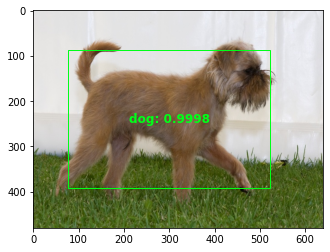

In [16]:
run(input_image, display=True)

## Use webcam

In [17]:
videoIn = cv2.VideoCapture(0)
videoIn.set(cv2.CAP_PROP_FRAME_WIDTH, 640);
videoIn.set(cv2.CAP_PROP_FRAME_HEIGHT, 480);

print("Capture device is open: " + str(videoIn.isOpened()))

Capture device is open: True


In [18]:
ret, frame = videoIn.read()

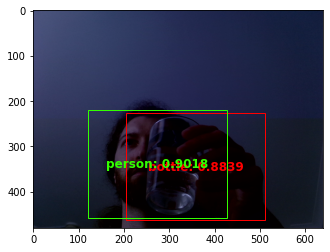

In [19]:
boxes, scores, classes = run(frame, display=True)

In [20]:
best_score = np.argmax(scores)
class_names[classes[best_score]]

'person'

Print object to pmod grove oled

In [21]:
oled = adapter.G4
oled.set_default_config()
oled.set_normal_display()
# oled.set_inverse_display()
oled.put_string(f"Detected: {class_names[classes[best_score]]}") 

## Stream from webcam

In [22]:
videoIn.release()
cap = cv2.VideoCapture(0)

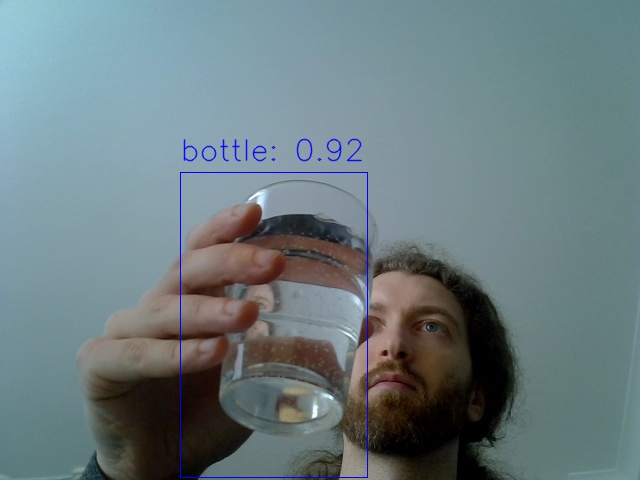

In [23]:
display_handle=display(None, display_id=True)

Keeping track of only best scoring object in the image...

In [24]:
last_object = "None"

# while True:
for i in range(100):
    _, frame = cap.read()
    boxes, scores, classes = run(frame)
    
    if scores.any():

        best_score = np.argmax(scores)

        # Draw bounding box
        y_min,x_min,y_max,x_max = map(int, boxes[best_score])
        frame = cv2.rectangle(frame, (x_min,y_min), (x_max, y_max), color=255)

        # Label
        text = f"{class_names[classes[best_score]]}: {scores[best_score]:.2f}"
        text_size = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)[0]
        frame = cv2.putText(frame, text, (x_min, y_min-text_size[1]), cv2.FONT_HERSHEY_SIMPLEX, 1, 255, 1, cv2.LINE_AA)

        _, frame = cv2.imencode('.jpeg', frame)
        display_handle.update(Image(data=frame.tobytes()))
        
        if class_names[classes[best_score]] == last_object:
            pass
        else:
            oled.clear_display()
            oled.put_string(class_names[classes[best_score]])
            last_object = class_names[classes[best_score]]

----

Copyright (C) 2021 Xilinx, Inc

SPDX-License-Identifier: Apache-2.0 License

----

----